In [1]:
#GPU:

import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
import tensorflow as tf

seed = 1

np.random.seed(1)
tf.random.set_seed(1)

2023-04-14 18:23:50.081224: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [4]:
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

In [5]:
classifier(["This is such a great movie!",
            "This show was not interesting ",
            "This show was interesting", 
            "This show was not bad at all", 
            "I can't say that this was a good movie", 
            "This course is just what I needed.", 
            "I can't understand any of this. Instructor kept telling me to meet the \ prerequisites. What are prerequisites? Why does he keep saying that?"
           ])

[{'label': 'POSITIVE', 'score': 0.9998759031295776},
 {'label': 'NEGATIVE', 'score': 0.9997871518135071},
 {'label': 'POSITIVE', 'score': 0.999747097492218},
 {'label': 'POSITIVE', 'score': 0.998742401599884},
 {'label': 'NEGATIVE', 'score': 0.9278467893600464},
 {'label': 'POSITIVE', 'score': 0.9991594552993774},
 {'label': 'NEGATIVE', 'score': 0.9973132014274597}]

## Using GPU:

In [6]:
import torch
torch.cuda.is_available()

True

In [7]:
torch.cuda.current_device() #this is what we are going to use as 'device'

0

#### Classifier:

In [8]:
claclassifier = pipeline("sentiment-analysis", device=0)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


#### Upload the dataset:

In [9]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

File ‘AirlineTweets.csv’ already there; not retrieving.



In [10]:
df_ = pd.read_csv('AirlineTweets.csv')

In [11]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


#### Some data preprocessing:

In [12]:
#the columns we need:
df = df_[['airline_sentiment', 'text']].copy()

In [13]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<AxesSubplot: >

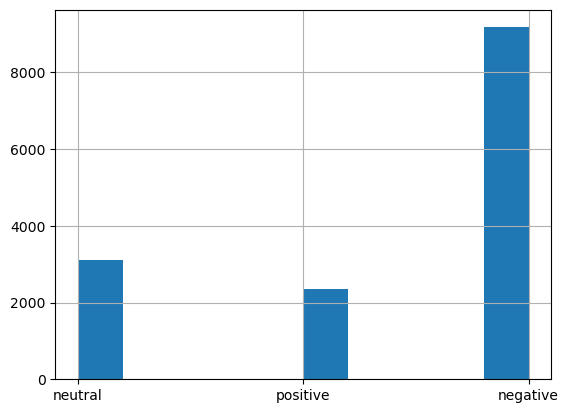

In [14]:
df['airline_sentiment'].hist()

In [15]:
#deleting the 'neutral' label because the Hugging Face classifier can only detect two labels.
df = df[df.airline_sentiment != 'neutral'].copy()

In [16]:
target_map = {'positive':1, 'negative':0}
df['target'] = df['airline_sentiment'].map(target_map)

In [17]:
df

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1
...,...,...,...
14633,negative,@AmericanAir my flight was Cancelled Flightled...,0
14634,negative,@AmericanAir right on cue with the delays👌,0
14635,positive,@AmericanAir thank you we got on a different f...,1
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,0


In [18]:
len(df)

11541

#### Data predictions:

In [19]:
texts_from_df = df['text'].tolist()
preds = classifier(texts_from_df)

In [20]:
preds

[{'label': 'POSITIVE', 'score': 0.6070849299430847},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854250550270081},
 {'label': 'POSITIVE', 'score': 0.9553212523460388},
 {'label': 'POSITIVE', 'score': 0.9827088117599487},
 {'label': 'POSITIVE', 'score': 0.9994851350784302},
 {'label': 'POSITIVE', 'score': 0.9993509650230408},
 {'label': 'POSITIVE', 'score': 0.9940821528434753},
 {'label': 'POSITIVE', 'score': 0.9863133430480957},
 {'label': 'POSITIVE', 'score': 0.9996304512023926},
 {'label': 'NEGATIVE', 'score': 0.9980512857437134},
 {'label': 'POSITIVE', 'score': 0.9964436888694763},
 {'label': 'NEGATIVE', 'score': 0.9968666434288025},
 {'label': 'POSITIVE', 'score': 0.9787647724151611},
 {'label': 'POSITIVE', 'score': 0.9995218515396118},
 {'label': 'NEGATIVE', 'score': 0.9954516291618347},
 {'label': 'POSITIVE', 'score': 0.9995624423027039},
 {'label': 'POSITIVE', 'score': 0.999874830245

#### Compare predictions with targets:

In [21]:
#or: preds_lst_int = [1 if i['label'] == 'POSITIVE' else 0 for i in preds]
preds_lst_int = []
for i in preds:
    if i['label'] == 'POSITIVE': #or i['label'].startswith('P')
        preds_lst_int.append(1)
    else:
        preds_lst_int.append(0)

preds_lst_int = np.array(preds_lst_int)

In [22]:
preds_lst_int

array([1, 0, 0, ..., 1, 0, 0])

In [27]:
cm = confusion_matrix(df['target'], preds_lst_int) #wecan put 'normalize = 'true'' so that each row sums to one.
ac = accuracy_score(df['target'], preds_lst_int)
ac_2 = np.mean(df['target'] == preds_lst_int) 
#it is good accuracy especially for a model thathas not seen tweets before
#however, the + and - labels were not normal, so accuracy could be misleading!

In [29]:
ac

0.8898708950697514

In [30]:
ac_2

0.8898708950697514

In [34]:
cm

array([[8271,  907],
       [ 364, 1999]])

In [ ]:
#Now, let's show cm in a more presentable manner:

<AxesSubplot: >

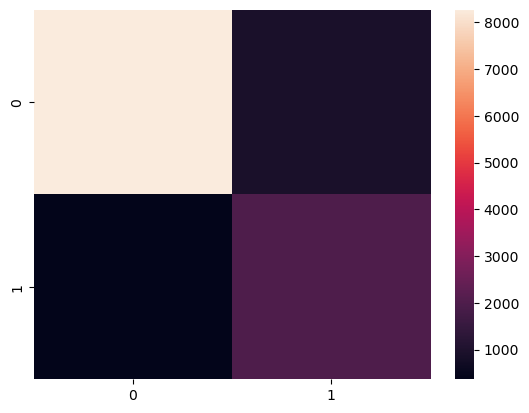

In [35]:
sn.heatmap(cm)

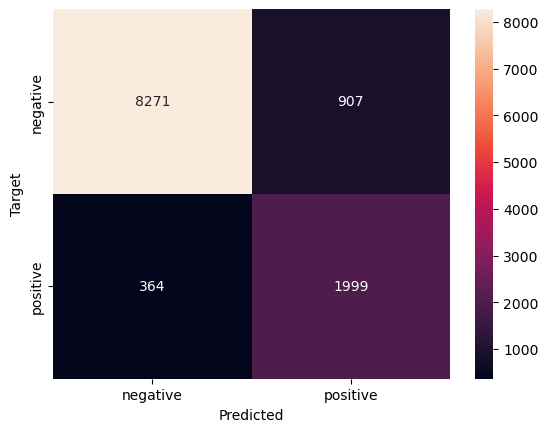

In [38]:
#or:
def plot_heatmap_cm(cm):
    classes = ['negative', 'positive']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Target')
    
plot_heatmap_cm(cm)

In [46]:
print(f1_score(df['target'], preds_lst_int)) #assingning 1 to positive labels
print(f1_score(1-df['target'], 1 - preds_lst_int)) #assingning 1 to negative labels

#So now we can see that the new F one score is about 93% and thus it really depends on which label we assign to zero 
#and which label we assign as one.

0.7587777566900741
0.928647616908999


In [47]:
#or: probs = [i['score'] if i['label'] == 'POSITIVE' else 1-i['score'] for i in preds]
probs = []
for i in preds:
    if i['label'] == 'POSITIVE': #or i['label'].startswith('P')
        probs.append(i['score'])
    else:
        probs.append(1-i['score'])

probs = np.array(probs)
print(roc_auc_score(df['target'], probs))
print(roc_auc_score(1-df['target'], 1-probs))

0.9485934229556097
0.9485934229556096
